In [18]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [19]:
# load data
df = pd.read_csv('../../data/H2.csv')

In [20]:
#  Train-Test Split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.shape, test_df.shape

((63464, 31), (15866, 31))

In [21]:
# Handle missing values
train_df['Children'].fillna(0, inplace=True)  # Fill missing 'Children' with 0
train_df['Country'].fillna('Unknown', inplace=True)  # Fill missing 'Country' with 'Unknown'

# Drop rows where adults, babies and children are zero at the same time
train_df = train_df[(train_df['Adults'] != 0) | (train_df['Babies'] != 0) | (train_df['Children'] != 0)] 

In [22]:
# Remove Outliers
# Get only numerical data
train_df_num = train_df.select_dtypes(include=[np.number])
# Get only Categorical data
train_df_cat = train_df.select_dtypes(include=["object"])

train_df_num_out = train_df_num[["LeadTime", "ADR"]]

# Outlier Detection Fonksion
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Remove Outliers
def remove_outliers(data, outliers):
  return data.drop(outliers.index)

for col in train_df_num_out:
  outliers = detect_outliers_iqr(train_df, col)
  train_df = remove_outliers(train_df, outliers)
  print(f"{col}: {len(outliers)} outliers removed.")

train_df.shape

LeadTime: 306 outliers removed.
ADR: 370 outliers removed.


(62659, 31)

In [23]:
# Define a dictionary to map country codes to regions
country_to_region = {
    "PRT": "Europe",
    "GBR": "Europe",
    "ESP": "Europe",
    "IRL": "Europe",
    "NLD": "Europe",
    "RUS": "Europe",
    "FRA": "Europe",
    "DEU": "Europe",
    "ITA": "Europe",
    "BEL": "Europe",
    "CHE": "Europe",
    "USA": "North America",
    "CAN": "North America",
    "MEX": "North America",
    "CN": "Asia",
    "BRA": "South America",
    "ARG": "South America",
    "AUS": "Oceania",
    "Unknown": "Unknown",
}

# Map the country codes to regions
train_df["Region"] = train_df["Country"].map(country_to_region)

# Drop the Country column
train_df.drop(columns=["Country"], inplace=True)

In [24]:
# Remove blank spaces from the 'Agent' column
train_df['Agent'] = train_df['Agent'].str.strip()

# Replace 'NULL' values in the 'Agent' column with 0
train_df['Agent'].replace('NULL', 0, inplace=True)

# Convert the 'Agent' column to integer
train_df['Agent'] = train_df['Agent'].astype(int)

In [25]:
# Columns to drop from the dataset
columns_to_drop = [
    'IsCanceled', 
    'ReservationStatus', 
    'ReservationStatusDate', 
    'ArrivalDateYear', 
    'ArrivalDateMonth', 
    'ArrivalDateWeekNumber', 
    'ArrivalDateDayOfMonth', 
    'Company'
]

# Drop the specified columns
train_df = train_df.drop(columns=columns_to_drop)

In [26]:
# Create new Features

# TotalStay
train_df["TotalStay"] = train_df["StaysInWeekendNights"] + train_df["StaysInWeekNights"]

# SpendingPerPerson
train_df["SpendingPerPerson"] = train_df["ADR"] / (train_df["Adults"] + train_df["Children"] + train_df["Babies"])
train_df["SpendingPerPerson"].fillna(0, inplace=True)  # Handle division by zero

# GroupType
def determine_group_type(row):
    if row["Adults"] == 1 and (row["Children"] + row["Babies"] == 0):
        return "Single"
    elif row["Adults"] == 2 and (row["Children"] + row["Babies"] == 0):
        return "Couple"
    elif (row["Children"] + row["Babies"]) > 0:
        return "Family"
    elif row["Adults"] > 2:
        return "Big_Group"
    else:
        return "Other"

train_df["GroupType"] = train_df.apply(determine_group_type, axis=1)

# BookingUrgency
def determine_booking_urgency(lead_time):
    if lead_time > 60:
        return "Early_Booking"
    elif 30 <= lead_time <= 60:
        return "Medium_Term_Booking"
    else:
        return "Last_Minute_Booking"

train_df["BookingUrgency"] = train_df["LeadTime"].apply(determine_booking_urgency)

# HighDemand
train_df["HighDemand"] = train_df["TotalOfSpecialRequests"].apply(lambda x: "High" if x >= 2 else "Low")

# LoyaltyScore
train_df["LoyaltyScore"] = train_df["IsRepeatedGuest"] * (train_df["PreviousBookingsNotCanceled"] + 1)

# ChildRatio
train_df["ChildRatio"] = ((train_df["Children"] + train_df["Babies"]) / (train_df["Adults"] + train_df["Children"] + train_df["Babies"])).round(2)
train_df["ChildRatio"].fillna(0, inplace=True)  # Handle division by zero

# Occupancy
train_df["Occupancy"] = np.where(train_df["TotalStay"] == 0, 0, 
                                (train_df["Adults"] + train_df["Children"] + train_df["Babies"]) / train_df["TotalStay"]).round(2)

# WaitingTimeCategory
def determine_waiting_time_category(days):
    if days < 7:
        return "Short"
    elif 7 <= days <= 30:
        return "Medium"
    else:
        return "Long"

train_df["WaitingTimeCategory"] = train_df["DaysInWaitingList"].apply(determine_waiting_time_category)

# CancellationRisk
train_df["CancellationRisk"] = train_df["PreviousCancellations"] * train_df["LeadTime"]

# Check new Features
train_df.head()

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,Region,TotalStay,SpendingPerPerson,GroupType,BookingUrgency,HighDemand,LoyaltyScore,ChildRatio,Occupancy,WaitingTimeCategory,CancellationRisk
12826,71,0,3,1,0.0,0,BB,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,236,0,Transient,120.00,0,0,Europe,3,120.00,Single,Early_Booking,Low,0,0.00,0.33,Short,0
36957,0,0,2,2,0.0,0,BB,Direct,Direct,0,0,0,A,A,0,No Deposit,0,0,Transient,106.00,0,1,Europe,2,53.00,Couple,Last_Minute_Booking,Low,0,0.00,1.00,Short,0
46297,0,0,1,2,1.0,0,BB,Online TA,TA/TO,0,0,0,A,D,0,No Deposit,9,0,Transient,138.00,0,0,Europe,1,46.00,Family,Last_Minute_Booking,Low,0,0.33,3.00,Short,0
12562,27,0,1,2,0.0,0,BB,Offline TA/TO,Corporate,0,0,0,A,A,0,No Deposit,191,0,Transient-Party,120.00,0,0,Europe,1,60.00,Couple,Last_Minute_Booking,Low,0,0.00,2.00,Short,0
37239,256,1,2,1,0.0,0,BB,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,4,0,Transient-Party,64.33,0,0,South America,3,64.33,Single,Early_Booking,Low,0,0.00,0.33,Short,0


In [27]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Numeric and Categorical Columns
numeric_columns = train_df.select_dtypes(include=[np.number]).columns
categorical_columns = train_df.select_dtypes(include=["object"]).columns

numeric_columns, categorical_columns


(Index(['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults',
        'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations',
        'PreviousBookingsNotCanceled', 'BookingChanges', 'Agent',
        'DaysInWaitingList', 'ADR', 'RequiredCarParkingSpaces',
        'TotalOfSpecialRequests', 'TotalStay', 'SpendingPerPerson',
        'LoyaltyScore', 'ChildRatio', 'Occupancy', 'CancellationRisk'],
       dtype='object'),
 Index(['Meal', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType',
        'AssignedRoomType', 'DepositType', 'CustomerType', 'Region',
        'GroupType', 'BookingUrgency', 'HighDemand', 'WaitingTimeCategory'],
       dtype='object'))

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Pipeline for numeric columns
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline for categorical columns
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Define processors for both types
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_columns),
    ("cat", categorical_pipeline, categorical_columns)
])

---

In [29]:
# Transform data and put the result into a DataFrame
processed_data = preprocessor.fit_transform(train_df)

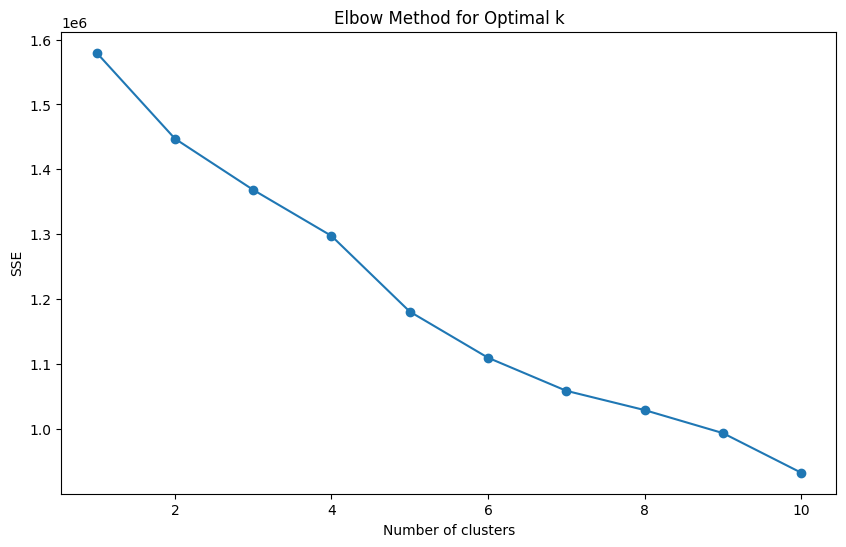

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

- There is an elbow at 5 and can be 7 

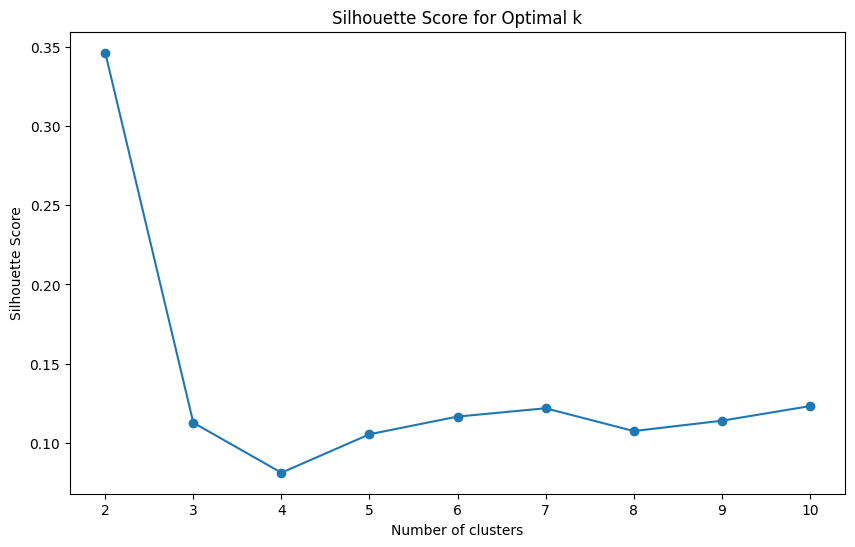

In [31]:
# Silhouette Score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_data)
    score = silhouette_score(processed_data, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

- Silhouette Score at 5 is not as good, can use 7.

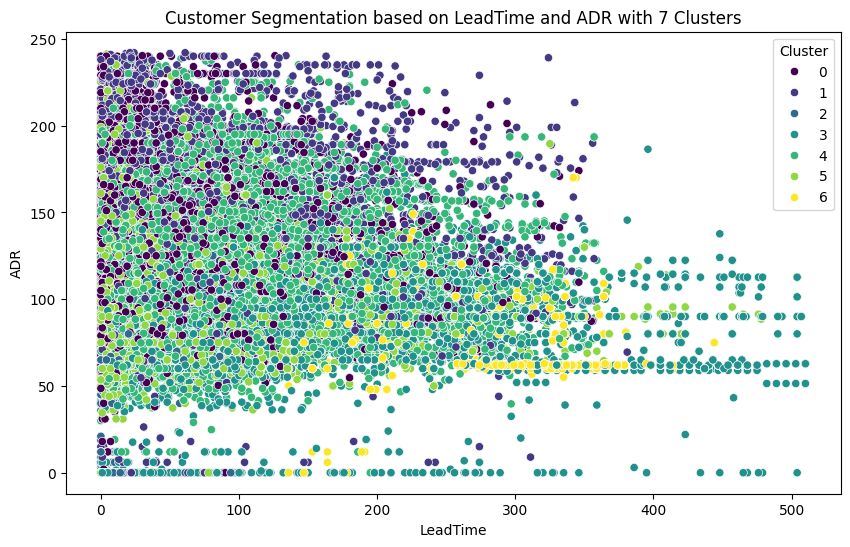

,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,Region,TotalStay,SpendingPerPerson,GroupType,BookingUrgency,HighDemand,LoyaltyScore,ChildRatio,Occupancy,WaitingTimeCategory,CancellationRisk,Cluster,ClusterName
12826,71,0,3,1,0.0,0,BB,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,236,0,Transient,120.00,0,0,Europe,3,120.00,Single,Early_Booking,Low,0,0.00,0.33,Short,0,5,Frequent Cancellers
36957,0,0,2,2,0.0,0,BB,Direct,Direct,0,0,0,A,A,0,No Deposit,0,0,Transient,106.00,0,1,Europe,2,53.00,Couple,Last_Minute_Booking,Low,0,0.00,1.00,Short,0,0,Early Bookers
46297,0,0,1,2,1.0,0,BB,Online TA,TA/TO,0,0,0,A,D,0,No Deposit,9,0,Transient,138.00,0,0,Europe,1,46.00,Family,Last_Minute_Booking,Low,0,0.33,3.00,Short,0,1,High Spenders
12562,27,0,1,2,0.0,0,BB,Offline TA/TO,Corporate,0,0,0,A,A,0,No Deposit,191,0,Transient-Party,120.00,0,0,Europe,1,60.00,Couple,Last_Minute_Booking,Low,0,0.00,2.00,Short,0,0,Early Bookers
37239,256,1,2,1,0.0,0,BB,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,4,0,Transient-Party,64.33,0,0,South America,3,64.33,Single,Early_Booking,Low,0,0.00,0.33,Short,0,5,Frequent Cancellers


In [32]:
# KMeans with 7 clusters
kmeans = KMeans(n_clusters=7, random_state=42)
y_pred = kmeans.fit_predict(processed_data)

# Add cluster labels to the original dataframe
train_df['Cluster'] = y_pred

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LeadTime', y='ADR', hue='Cluster', data=train_df, palette='viridis')
plt.title('Customer Segmentation based on LeadTime and ADR with 7 Clusters')
plt.show()

# Name the clusters based on their characteristics
cluster_names = {
    0: 'Early Bookers',
    1: 'High Spenders',
    2: 'Family Travelers',
    3: 'Short Stay Guests',
    4: 'Long Stay Guests',
    5: 'Frequent Cancellers',
    6: 'Last Minute Bookers'
}

# Map the cluster labels to the names
train_df['ClusterName'] = train_df['Cluster'].map(cluster_names)

# Display the first few rows of the dataframe with the new cluster names
train_df.head()